# Exp5. House Price Prediction - KaKR

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# seaborn scheme 세팅 (이유한님 커널 참고), 일일이 font_scale 지정 불필요
plt.style.use('seaborn')
sns.set(font_scale=1.5)

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## EDA

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


date 컬럼을 연도와 월까지만 정수형 타입이 되도록 처리하자. train과 test에 대해 동일하게 처리한다. 

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


id 컬럼은 불필요하므로 삭제한다.

In [5]:
del train['id']
del test['id']

print(train.columns)
print(test.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


target 컬럼인 price의 분포를 시각화해보자.

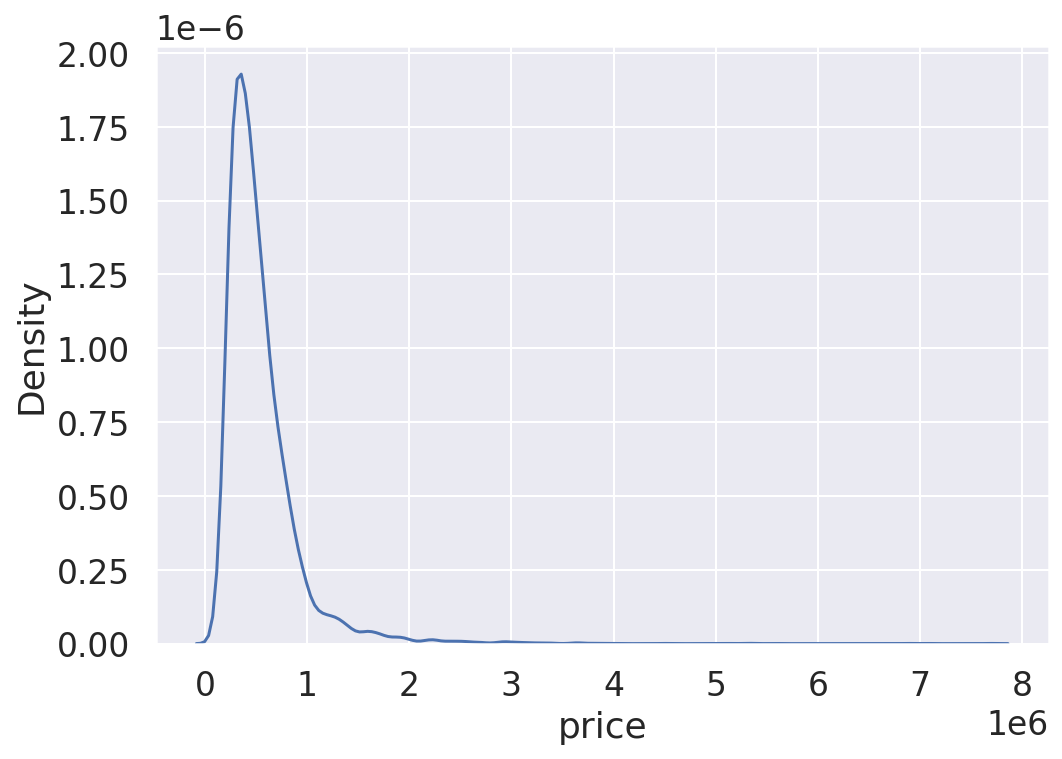

In [6]:
sns.kdeplot(train['price'])
plt.show()

price의 분포가 한 쪽으로 많이 치우쳐있다. 이렇게 정규분포가 아닌 치우친 분포를 가지는 경우 모델의 예측 성능이 떨어질 수 있기 때문에 Normalize해야한다.  
우선 price와 다른 컬럼들의 상관관계를 확인하기 위해 스피어만 상관관계를 나타낸 히트맵을 그려보자.   
>스피어만 순위 상관관계 : grade 컬럼과 같은 범주형 변수가 포함되었을 경우에 사용한다. (피어슨은 연속형 변수에 사용한다고 한다)

<AxesSubplot:>

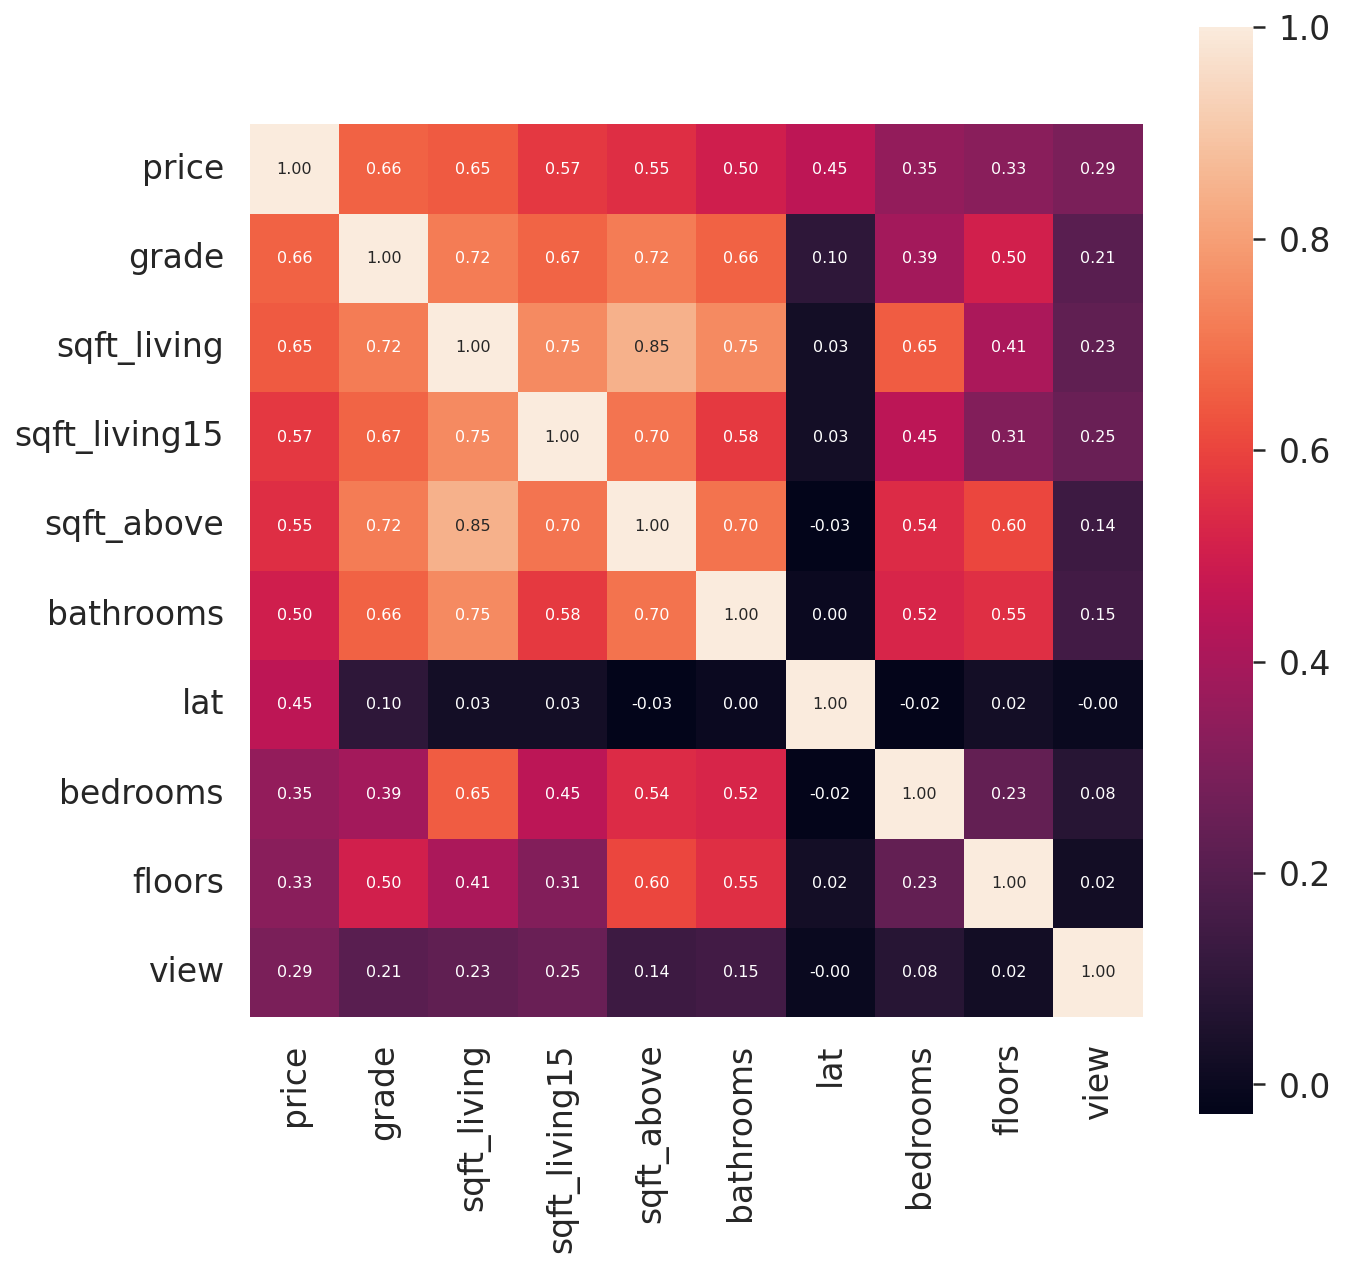

In [7]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index  # price와 상관도가 높은 10개의 컬럼 추출

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
plt.figure(figsize=(10, 10))
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8},
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

price와 상관도가 높은 컬럼은 순서대로 grade, sqft_living, sqft_living15, sqft_above가 있음을 알 수 있다.

## Data Preprocessing

In [8]:
train.drop(columns=['lat', 'long'], inplace=True)
test.drop(columns=['lat', 'long'], inplace=True)

price에 거의 영향을 미치지 않는 것으로 보이는 lat, long 컬럼을 삭제했다.

In [9]:
train = pd.get_dummies(train, columns = ['yr_built', 'waterfront', 'zipcode'])
test = pd.get_dummies(test, columns = ['yr_built', 'waterfront', 'zipcode'])

범주형 변수인 yr_built, waterfront, zipcode 컬럼을 one-hot encoding했다. 

In [10]:
y = np.log1p(train['price'])
del train['price']

모델 학습을 위해 train의 타겟 컬럼 price를 분리했다. 분리한 price 컬럼은 로그변환해 Normalize한다.

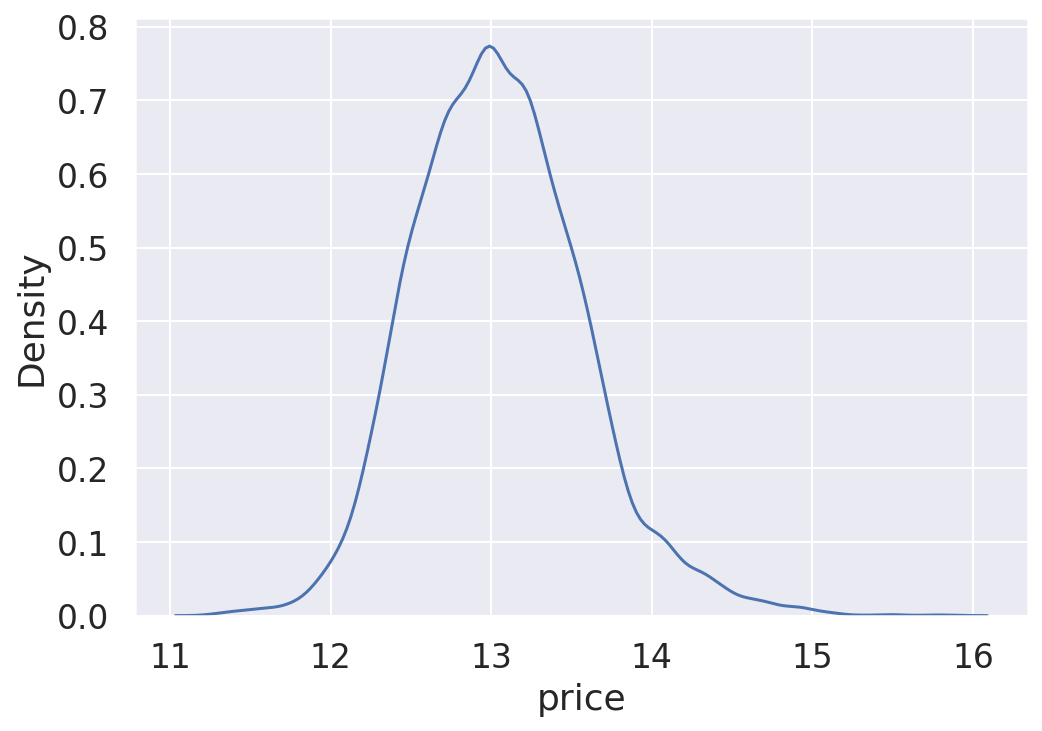

In [11]:
sns.kdeplot(y)
plt.show()

price의 분포가 보다 정규분포에 가까워진 것을 확인할 수 있다.

In [12]:
# 대회의 평가 척도인 RMSE를 계산하기 위한 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [13]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [14]:
def get_score(models, train, y):
    # 각 모델 별 학습 및 예측
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 RMSE값 저장
        df[model_name] = rmse(y_test, y_pred)

        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [15]:
# 그리드 탐색 후 결과 확인 과정을 하나의 함수로
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                             cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [29]:
param_grid ={
    'n_estimators' : [50, 300],
    'max_depth' : [1, 20],
    #'learning_rate' : [0.01, 0.03]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,20,300,-0.031684,0.178000
2,20,50,-0.040702,0.201746
1,1,300,-0.060831,0.246639
0,1,50,-0.117408,0.342648


In [17]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [30]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.178')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.178.csv saved!
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.03, max_depth=20, n_estimators=50; total time=   0.5s
[CV] END .learning_rate=0.03, max_depth=20, n_estimators=100; total time=   0.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.0s
[CV] END .....................

Private Score : 123589.97131...